# C-MAPSS Anomaly Detection Autoencoder

La detección de anomalías (Anomaly Detection) sobre sistemas con una alta dimensionalidad de datos, es un problema de particular interés tanto en el campo del Machine Learning como también en diversas áreas de la ingeniería e industria. En particular, los algoritmos de detección de anomalías resultan de suma relevancia a la hora de desarrollar e implementar sistemas de monitoreo de equipos o activos industriales de mayor complejidad.

En términos generales, un algoritmo de detección de anomalías cumple la función de reconocer patrones o colecciones de datos que escapan del estado nominal del sistema analizado. Estadísticamente, estos algoritmos generar un mapeo multidimensional de probabilidad, donde las anomalías consisten en los puntos `outliers` que se encuentran en áreas con una baja densidad de probabilidad respecto al estado de operación nominal.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_05/bin/nasa_logo.png" height="200"><img src="https://www.researchgate.net/profile/Xiaolei_Fang/publication/310789705/figure/fig2/AS:462413100261377@1487259282977/Simplified-diagram-of-engine-simulated-in-C-MAPSS-6.png" height="200">

En este workshop volveremos a utilizar el C-MAPSS Dataset de la NASA para desarrollar un detector de anomalías mediante un Autoencoder. Así, en este caso reconfiguraremos los datos de las simulaciones ya no para predecir el tiempo de vida remanente o Remaining Useful Life (RUL) de cada turbina, sino para clasificar si la turbina se encuentra en un estado de operación nominal o en uno de degradación crítica.

El `autoencoder` que implementaremos mediante `keras` y `tensorflow` tendrá la finalidad de reconstruir, mediante un modelo `encoder` y otro `decoder`, la serie temporal del registro de los 14 sensores del sistema. De esta manera, al entrenar el `autoencoder` únicamente sobre las secuencias correspondientes a un estado `nominal` de operación, se espera que al ingresar series temporales en un estado `degradado` el `autoencoder` presente un desempeño considerablemente menor.



## C-MAPSS Dataset

Como recordatorio, el C-MAPSS dataset que utilizaremos en esta ocación consiste en múltiples simulaciones de degradación de motores turbofán bajo distintas condiciones, tanto mecánicas como operacionales. En este sentido, el dataset se compone de más de `27000` series temporales de los sensores del turbofán que, gracias a la simulación de este, han podido ser asociadas al RUL del motor.

En esta sección nos encargaremos de cargar y explorar el dataset que utilizaremos, denominado `C-MAPSS FD001`, que contiene `100` simulaciones de motores mecánicamente distintos bajo condiciones nominales de operación. Nuevamente, para facilitar la carga del dataset a este entorno de Google Colab el achivo `CMAPSS_FD001.npz` ha sido cargado a un Google Drive.

In [2]:
!pip install -U -q PyDrive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# inicializar GoogleDrive con credenciales de autorización
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# crear carpeta para descargar los archivos .npz
!mkdir /content/datasets

# Google Drive IDs para descargar los archivos .npz
files_id = [('CMAPSS_FD001.npz', '1DNJFrQKB4I7SqjpFmM5SsKRaN7O9XCNZ')]

# comenzar descarga
print('descargando datasets: ', end='')

for filename, id in files_id:
  save_path = os.path.join('/content/datasets', filename)

  # descargar y guardar en /content/datasets
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(save_path)

# indicar descarga terminada
print('done')

descargando datasets: done


Carguemos este archivo mediante `np.load()` y exploremos las estructuras y datos que contiene.

In [3]:
import numpy as np

# cargar archivo CMAPSS_FD001.npz
dataset = np.load('/content/datasets/CMAPSS_FD001.npz', allow_pickle=True)

# print keys del dataset
print(  list( dataset.keys() ) )

['x_train', 'y_train', 'x_test', 'y_test', 'image_format', 'allow_pickle']


También, como ya es rutinario, aprovecharemos de cargar el GitHub del curso deeplearningfallas para disponer de algunas utilidades que nos serán de utilidad más adelante.

In [4]:
# cargar GitHub https://github.com/cherrerab/deeplearningfallas.git
%cd /content/
!git clone https://github.com/cherrerab/deeplearningfallas.git
%cd /content/deeplearningfallas

/content
Cloning into 'deeplearningfallas'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 376 (delta 50), reused 0 (delta 0), pack-reused 249
Receiving objects: 100% (376/376), 37.59 MiB | 11.88 MiB/s, done.
Resolving deltas: 100% (138/138), done.
/content/deeplearningfallas


---
# Training Data

Como ya sabemos, el dataset se encuentra previamente separado en conjuntos de `training` y `testing`. En particular, cada uno de estos conjuntos están separados en `100` simulaciones de turbinas distintas. Luego, cada una de estas simulaciones contiene varias muestras de series temporales registradas durante la operación que están asociadas a un valor RUL en el conjunto `Y_train` o `Y_test`.

Nuevamente, para generar los conjuntos `training` y `testing` que finalmente utilizaremos para desarrollar nuestros modelos, debemos concatenar las series de todas las simulaciones de `C-MAPSS` y modificar sus dimensiones para que sean compatibles con las capas y estructuras de `tensorflow` y `keras`. En particular, recordemos que los datos de cada simulación en el conjunto `X_train` son de la forma `(n_samples, n_timesteps, n_features, 1)`. Donde en este caso `n_features` corresponde a la cantidad de sensores dentro de la simulación (`14`), mientras `n_timesteps` corresponde a la cantidad de puntos temporales o mediciones dentro de la serie (`30`). Por otro lado, los datos del conjunto `Y_train` son de la forma `(n_samples, 1)`, donde cada valor corresponde al RUL de las respectivas series temporales en el conjunto `X_train`.

En este caso, a diferencia del workshop anterior, aplanaremos las series temporales de cada sample en un único vector de la forma `(n_timesteps*n_features, )`, pues consideraremos cada punto dentro del registro temporal como una dimensión que define el espacio vectorial de nuestra colección de datos.

In [46]:
# extraer conjuntos de training y testing del dataset
X_train, Y_train = dataset['x_train'], dataset['y_train']
X_test, Y_test = dataset['x_test'], dataset['y_test']

# ---
# concatenar y reconfigurar datos de las 100 simulaciones CMAPSS
# en este caso reordenaremos cada sample de la forma (n_timesteps*n_features)
# para ingresarlos al autoencoder que desarrollaremos.

# los datos X deben ser de la forma (n_samples, n_timesteps*n_features)
X_train = np.vstack( X_train )
X_train = np.reshape( X_train, (-1, 30*14) )

X_test = np.vstack( X_test )
X_test = np.reshape( X_test, (-1, 30*14) )

# los datos Y deben ser de la forma (n_samples, 1)
Y_train = np.vstack( Y_train )
Y_train = np.reshape( Y_train, (-1, 1) )

Y_test = np.vstack( Y_test )
Y_test = np.reshape( Y_test, (-1, 1) )

# print dimensiones de los nuevos conjuntos
print('X_train.shape: ', X_train.shape)
print('Y_train.shape: ', Y_train.shape)
print('\nX_test.shape: ', X_test.shape)
print('Y_test.shape: ', Y_test.shape)


X_train.shape:  (17731, 420)
Y_train.shape:  (17731, 1)

X_test.shape:  (10196, 420)
Y_test.shape:  (10196, 1)


Ahora, como se mencionó en la introducción de este workshop, para el entrenamiento del `autoencoder` que desarrollaremos utilizaremos únicamente datos o `samples` que presenten una condición `nominal` de operación. Arbitrariamente definirimos esta condición en función del RUL de cada sample, donde aquellos que presenten un RUL menor a 0.3, se encontrarán en un estado de degradación.

In [47]:
# ---
# segementar samples que presenten una serie temporal de operación 'nominal'
# en este caso, un sample 'nominal' es aquel cuyo RUL > 0.3

# obtener indices nominal_idx de samples nominales
RUL_train = Y_train.flatten() 
nominal_idx = np.where( RUL_train > 0.3 )[0]

# segementar X_train con samples nominales
X_train_nominal = X_train[nominal_idx, :]

# print dimensiones de este nuevo conjunto
print('X_train_nominal.shape: ', X_train_nominal.shape)

X_train_nominal.shape:  (11587, 420)


Como tenemos una gran cantidad de datos tanto en el conjunto de `training`, como en el de `testing`, siguiendo el procedimiento apropiado para el desarrollo de modelos de deep learning, utilizaremos la función `sklearn.train_test_split` para generar un conjunto de `validation`.

In [48]:
from sklearn.model_selection import train_test_split

# ---
# realizar data splitting para generar los conjuntos (X_train_AE, X_val_AE)
# para el entrenamiento del autoencoder.

# dado que los autoencoders son modelos de reeconstrucción, en este caso
# no es necesario extraer conjuntos Y.
X_train_AE, X_val_AE, _, _ = train_test_split(X_train_nominal, X_train_nominal,
                                              train_size=0.8 , test_size=0.2 ,
                                              random_state=217 )

# print sample distribution
print( 'train split: {:d} samples'.format(X_train_AE.shape[0]) )
print( '\nvalidation split: {:d} samples'.format(X_val_AE.shape[0]) )

train split: 9269 samples

validation split: 2318 samples


---
# Model Building

Ahora comenzaremos a implementar el `autoencoder` en que se centra el trabajo de este workshop. Un `autoencoder`, en términos del deep learning, es una arquitectura de redes neuronales cuyo objetivo es reconstruir la información de entrada o bien, `input` de la red. En este sentido, un `autoencoder` perfecto es aquel que es capaz de reconstruir perfectamente los datos de entrada sin ninguna pérdida de información.

Pero entonces, si los `autoencoders` solo retornan la misma información que uno ingresa al modelo, que finalidad tiene implementar un modelo así?

En realidad, dentro de un `autoencoder` lo que importa no es la salida de este sino el `vector latente` que, en algún punto en su interior, concentra toda la información de los datos de entrada. Los `autoencoders` se componen de dos modelos independientes, pero que se entrenan en conjunto, el `encoder` y el `decoder`. Por un lado, el `encoder` se encarga de comprimir la información de los datos de entrada en un único vector latente cuya dimensionalidad puede ser significativamente menor a la del `input`, mientras que el `decoder` se encarga de aprender a reconstruir los datos originales que se ingresaron al `encoder`, únicamente a partir del vector latente resultante del `encoder`.

<img src="https://miro.medium.com/max/1000/0*uq2_ZipB9TqI9G_k" width="600">

## Model Setup

Para configurar nuestro modelo, debemos definir separadamente los modelos `encoder` y `decoder` que lo compondrán. Similar a la figura de arriba, para configurar nuestro modelo de regresión utilizaremos nuevamente la librería `keras` o `tf.keras` y se compondrá principalmente de capas `Dense`, también llamadas Fully Connected en la literatura.

- https://keras.io/api/layers/core_layers/dense/

De esta forma, en términos generales, compondremos nuestro `encoder` de una serie de capas `Dense`, que se encargarán de procesar la información y los features de los datos de entrada hasta una última capa `Dense` cuya cantidad de nodos definirá la dimensionalidad del `vector latente`. De la misma manera, ya sea simétricamente o no, el `decoder` recibirá como entrada el `vector latente` y mediante otra serie de capas `Dense` reconstruirá los datos originales.

In [49]:
import keras
from keras.models import Model
from keras.layers import Input

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Reshape

# en este caso crearemos el autoencoder usando la API Functional
# la API Functional de keras permite la creación de modelos de una
# manera mucho más flexible
# https://keras.io/guides/functional_api/

# ---
# primero debemos crear nuestra capa Input donde debemos especificar
# las dimensiones de los datos que se ingresarán al modelo
# en este caso el autoencoder recibe samples de la forma (420, )
input_dim = ( 420,  )
input_layer = Input( shape=input_dim )

# ---
# ahora debemos ir agregando nuestras capas Dense para configurar
# el modelo encoder.
# https://keras.io/api/layers/core_layers/dense/

encoder = Dense(units=256, activation='relu')(input_layer)
encoder = Dense(units=128, activation='relu')(encoder)

encoder = Dropout(rate=0.1)(encoder)

encoder = Dense(units=128, activation='relu')(encoder)
encoder = Dense(units=128, activation='relu')(encoder)

# ahora configuraremos la capa Dense cuyo output corresponderá al
# vector latente del autoencoder.
latent_dim = 64
latent_vector = Dense(units=latent_dim, activation='relu')(encoder)

# finalmente, debemos ir agregando nuestras capas Dense para configurar
# el decoder de nuestro modelo.
# en este caso hay que tener presente que la salida de esta sección
# debe tener la misma dimensionalidad o forma que los samples de entrada.

decoder = Dense(units=128, activation='relu')(latent_vector)
decoder = Dense(units=128, activation='relu')(decoder)

decoder = Dropout(rate=0.1)(decoder)

decoder = Dense(units=128, activation='relu')(decoder)
decoder = Dense(units=256, activation='relu')(decoder)

output_layer = Dense(units=420, activation='linear')(decoder)

# ---
# ahora configuraremos el modelo autoencoder que entrenaremos
autoencoder = Model(input_layer, output_layer)

# adicionalmente podemos configurar el modelo encoder
# para utilizarlo como un reductor dimensional
encoder_model = Model(input_layer, latent_vector)

# print model.summary()
autoencoder.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 420)]             0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               107776    
_________________________________________________________________
dense_31 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_33 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_34 (Dense)             (None, 64)              

## Compile Model

Antes de poner a entrenar al modelo, es necesario realizar unas configuraciones adicionales. En particular, debemos especificar la función de pérdida o `loss function` que se optimizará durante el entrenamiento y el método de optimización como SGD o Adam.
- https://keras.io/api/models/model_training_apis/
- https://keras.io/api/optimizers/

En este caso, dado que la función escencial del autoencoder es reconstruir la información de entrada, configuraremos el entrenamiento para reducir el error cuadrado medio (MSE) entre los datos originales y la reconstrucción o salida del autoencoder.

In [50]:
from keras.optimizers import Adam

# configurar optimizador Adam
# https://keras.io/api/optimizers/adam/
opt = Adam( learning_rate=1e-3 )

# ---
# compilar modelo siguiendo como función de pérdida
# en este caso, usaremos el error cuadrádo medio (mse)
autoencoder.compile(loss='mse', optimizer=opt, metrics=['mae'])

## Model Training
Hemos llegado a la parte final del proceso, para entrenar nuestro modelo debemos especificar los sets que utilizaremos para el proceso `(X_train, Y_train)`, la cantidad de `epochs` que durará el entrenamiento, y el `batch size` de muestras que se irán entregando al modelo a medida que este va iterativamente ajustando sus parámetros.

En este caso, es necesario especificar que los datos `Y_train` del entrenamiento son equivalentes a los datos de entrada `X_train`.

Epoch 1/150
37/37 [==============================] - 0s 11ms/step - loss: 0.0573 - mae: 0.1872 - val_loss: 0.0320 - val_mae: 0.1419
Epoch 2/150
37/37 [==============================] - 0s 6ms/step - loss: 0.0268 - mae: 0.1275 - val_loss: 0.0252 - val_mae: 0.1223
Epoch 3/150
37/37 [==============================] - 0s 6ms/step - loss: 0.0251 - mae: 0.1223 - val_loss: 0.0247 - val_mae: 0.1206
Epoch 4/150
37/37 [==============================] - 0s 7ms/step - loss: 0.0248 - mae: 0.1213 - val_loss: 0.0251 - val_mae: 0.1219
Epoch 5/150
37/37 [==============================] - 0s 6ms/step - loss: 0.0246 - mae: 0.1206 - val_loss: 0.0253 - val_mae: 0.1227
Epoch 6/150
37/37 [==============================] - 0s 6ms/step - loss: 0.0244 - mae: 0.1198 - val_loss: 0.0248 - val_mae: 0.1208
Epoch 7/150
37/37 [==============================] - 0s 6ms/step - loss: 0.0243 - mae: 0.1194 - val_loss: 0.0250 - val_mae: 0.1218
Epoch 8/150
37/37 [==============================] - 0s 7ms/step - loss: 0.0242 - 

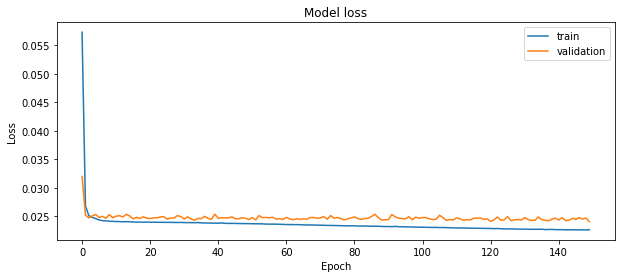

In [51]:
from utils import plot_loss_function

# realizar rutina de entrenamiento
train_history = autoencoder.fit(X_train_AE, X_train_AE,
                                batch_size=256, epochs=150,
                                validation_data=(X_val_AE, X_val_AE))

# plot gráfico de función de pérdida
plot_loss_function(train_history, figsize=(10,4))

## Model Evaluation

Ahora, recordemos que la razón incial del desarrollo de este autoencoder es analizar si este puede ser utilizado para segementar o bien, permitir el reconocimiento de series temporales que presenten un estado de degradación crítico. De este modo, evaluaremos si existe una diferencia significativa entre el error de reconstrucción sobre los datos `nominales` y los `degradados`. Para emplear el `autoencoder` sobre nuevas series temporales, conviene utilizar el método `keras.Model.predict`, análogamente a como hemos hecho en las arquitecturas anteriores.

Por otro lado, dado que estamos frente a un problema de regresión no podemos utilizar las herramientas de visualización anteriores como la matriz de consfusión. En este caso utilizaremos un `scatter plot` medainte la función `utils.plot_predict_scatter` para visualizar la correlación entre las predicciones `Y_pred` y los valores reales `Y_true`.

In [52]:
from utils import plot_predict_scatter

# ---
# obtener predicciones de X_test del modelo
# en primer lugar, similar a como hicimos para X_train
# debemos segmentar las series nominales de las degradadas.

# obtener indices nominal_idx de samples nominales
RUL_test = Y_test.flatten() 
nominal_idx = np.where( RUL_test > 0.3 )[0]
degraded_idx = np.where( RUL_test <= 0.3 )[0]

# segementar samples nominales y degradados
X_test_nominal = X_test[nominal_idx, :]
X_test_degraded = X_test[degraded_idx, :]

# obtener recontrucciones del autoencoder
AE_test_nominal = autoencoder(X_test_nominal)
AE_test_degraded = autoencoder(X_test_degraded)

# obtener el rmse de las reconstrucciones
rmse_nominal = np.sqrt( np.mean( np.power(X_test_nominal - AE_test_nominal, 2 ), axis=1) )
rmse_degraded = np.sqrt( np.mean( np.power(X_test_degraded - AE_test_degraded, 2 ), axis=1) )

print('nominal rmse: {:1.3f}'.format(np.mean(rmse_nominal)))
print('degraded rmse: {:1.3f}'.format(np.mean(rmse_degraded)))

nominal rmse: 0.156
degraded rmse: 0.167


Finalmente, podemos evaluar visualmente el desempeño de nuestro detector de anomalías ploteando mediante un `scatter` plot el rmse de reconstrucción de cada uno de los samples presentes en el `X_test`.

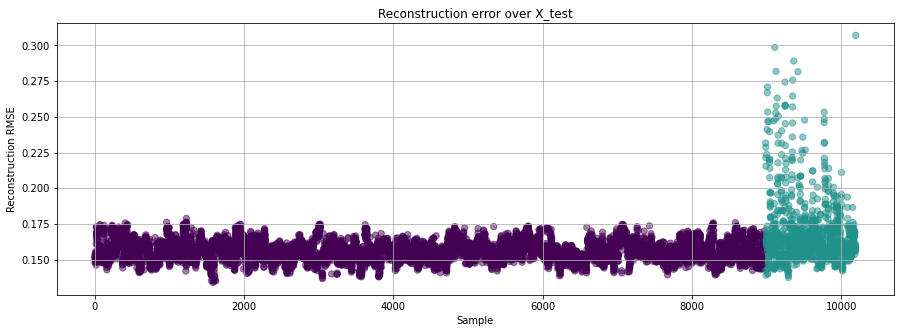

In [53]:
import matplotlib.pyplot as plt

# obtener predicciones sobre todo el test set
AE_test = autoencoder(X_test)
rmse_test = np.sqrt( np.mean( np.power(X_test - AE_test, 2 ), axis=1) )

# sort test samples para segmentar grupos nominales y degradados
sample_label = np.array( RUL_test <= 0.3, dtype=int )
sample_sort = np.argsort(sample_label)

sample_label = sample_label[sample_sort]
rmse_test = rmse_test[sample_sort]

# scatter error de reconstrucción
plt.figure( figsize=(15, 5) )
plt.title('Reconstruction error over X_test')
plt.xlabel('Sample'); plt.ylabel('Reconstruction RMSE')

plt.scatter(np.arange(rmse_test.size), rmse_test,
            c=list(sample_label), cmap='viridis', vmax=2.0, alpha=0.5, s=40)
plt.grid(True)

De esta manera, podemos ver que dentro del conjunto de series temporales degradadas existen puntos que escapan significativamente del rango de rmse. Podemos detectar o bien, asilar estos puntos definiendo un umbral o `threshold`.

detected anomalies:  187
accuracy: 15.48%


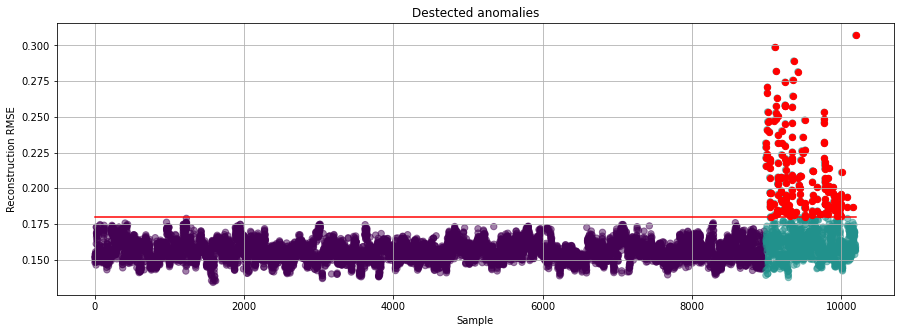

In [55]:
# ---
# detectar anomalías dentro del X_test

# umbral de rmse
threshold = 0.18

# obtener sample que superen el umbral
anomalies = np.where(rmse_test > threshold)[0]

accuracy = 100*anomalies.size/np.sum(RUL_test <= 0.3)

# print cantidad de anomalias detectadas
print('detected anomalies: ', anomalies.size)
print('accuracy: {:2.2f}%'.format(accuracy))

# ---
# visualizar en scatter plot
plt.figure( figsize=(15, 5) )
plt.title('Destected anomalies')
plt.xlabel('Sample'); plt.ylabel('Reconstruction RMSE')

plt.scatter(np.arange(rmse_test.size), rmse_test,
            c=list(sample_label), cmap='viridis', vmax=2.0, alpha=0.5, s=40)

plt.scatter(anomalies, rmse_test[anomalies], c='r', s=40)
plt.plot([0, rmse_test.size], [threshold, threshold], c='r')
plt.grid(True)


